In [1]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from gensim import corpora, models
from gensim.models.coherencemodel import CoherenceModel
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
import numpy as np
import os
nltk.download('punkt')
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
import colorcet as cc

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\yehao\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
allrecipe_df = pd.read_excel("./data/allrecipes_data.xlsx")
foodnetwork_df = pd.read_excel("./data/foodnetwork_data.xlsx")
kaggle_df = pd.read_csv("./data/kaggle_data.csv", index_col=0)

In [3]:
kaggle_df = kaggle_df[~kaggle_df['Instructions'].isna()]

In [4]:
df = pd.concat([allrecipe_df['food'], foodnetwork_df['food'], kaggle_df['Title']], axis=0).reset_index(drop=True)
recipe_names = df.values

In [5]:
recipe_names.shape

(49650,)

In [6]:
seen = set()
uniq = []
dups = {}
for name in recipe_names:
    if name not in seen:
        uniq.append(name)
        seen.add(name)
        dups[name] = 1
    else:
        dups[name] += 1
        
print("Unique recipes: ", len(uniq))
recipe_counts = sorted(dups.items(), key=lambda item: item[1], reverse=True)
print("Top 5 recipes: ", dict(recipe_counts[:5]))

Unique recipes:  48909
Top 5 recipes:  {'French 75': 5, 'Potato Latkes': 5, 'Banana Bread': 4, 'Daiquiri': 4, 'Manhattan': 4}


In [7]:
processed_names = []
stemmer = SnowballStemmer("english")
stopwords_list = stopwords.words("english")

for name in recipe_names:
    if not isinstance(name, str):
        name = str(name)
    else:
        name = name.lower()
        
    tokens = word_tokenize(name)
    filtered_words = [word for word in tokens if word.isalpha() and word not in stopwords_list]
    stemmed_words = [stemmer.stem(word) for word in filtered_words]
    
    processed_names.append(stemmed_words)     

processed_names[:10]

[['air', 'fryer', 'chicken', 'thigh'],
 ['air', 'fryer', 'heart', 'palm', 'stick'],
 ['air', 'fryer', 'spanakopita'],
 ['air', 'fryer', 'pecan', 'crust', 'trout'],
 ['air', 'fryer', 'tempura', 'veget'],
 ['air', 'fryer', 'roast', 'veget', 'gremolata', 'red', 'pepper', 'aioli'],
 ['crab', 'rangoon', 'air', 'fryer'],
 ['air', 'fryer', 'crispi', 'pickl', 'chip', 'creol', 'dip', 'sauc'],
 ['air', 'fryer', 'chicken', 'tender'],
 ['air', 'fryer', 'chicken', 'strip']]

In [8]:
dictionary = corpora.Dictionary(processed_names)
print(dictionary)

Dictionary<8223 unique tokens: ['air', 'chicken', 'fryer', 'thigh', 'heart']...>


In [9]:
# Convert dictionary to a Bag of Words corpus
corpus = [dictionary.doc2bow(name) for name in processed_names]
# (0, 1) means word at index 0 appeared one time
corpus[:5]

[[(0, 1), (1, 1), (2, 1), (3, 1)],
 [(0, 1), (2, 1), (4, 1), (5, 1), (6, 1)],
 [(0, 1), (2, 1), (7, 1)],
 [(0, 1), (2, 1), (8, 1), (9, 1), (10, 1)],
 [(0, 1), (2, 1), (11, 1), (12, 1)]]

In [10]:
lda_model = models.LdaModel(corpus, num_topics=40, id2word=dictionary, passes=1)

In [11]:
topics = lda_model.print_topics(num_topics=40, num_words=5)
topics[:5]

[(0,
  '0.462*"sauc" + 0.142*"sandwich" + 0.087*"cranberri" + 0.054*"sugar" + 0.047*"leek"'),
 (1,
  '0.138*"raspberri" + 0.104*"blueberri" + 0.072*"root" + 0.066*"winter" + 0.065*"mayonnais"'),
 (2,
  '0.533*"chicken" + 0.083*"honey" + 0.075*"goat" + 0.054*"artichok" + 0.037*"clam"'),
 (3,
  '0.531*"salad" + 0.098*"bacon" + 0.063*"brais" + 0.057*"fruit" + 0.057*"ricotta"'),
 (4,
  '0.242*"corn" + 0.201*"beef" + 0.090*"stew" + 0.089*"cabbag" + 0.075*"italian"')]

In [12]:
lda_coherence_model = CoherenceModel(model=lda_model, texts=processed_names, coherence='c_v')
lda_coherence = lda_coherence_model.get_coherence()

print("LDA Coherence:", lda_coherence)

LDA Coherence: 0.5960542223533356


In [13]:
recipes_with_topics = []
topic_distributions = []

for recipe_i in range(len(recipe_names)):
    # Get the topic distribution for the given recipe
    topic_distribution = lda_model.get_document_topics(corpus[recipe_i])
    topic_distributions.append(topic_distribution)
    
    sorted_topics = sorted(topic_distribution, key=lambda x: x[1], reverse=True)
    most_probable_topic = sorted_topics[0][0] if sorted_topics else None
    recipes_with_topics.append((recipe_names[recipe_i], most_probable_topic))

df_recipes_with_topics = pd.DataFrame(recipes_with_topics, columns=['Recipe Name', 'Assigned Topic'])

In [14]:
df_recipes_with_topics

,Recipe Name,Assigned Topic
0,Air Fryer Honey-Mustard Chicken Thighs,6
1,Air Fryer Hearts of Palm Sticks,6
2,Air Fryer Spanakopita,6
3,Air Fryer Pecan Crusted Trout,6
4,Air Fryer Tempura Vegetables,6
...,...,...
49645,Brownie Pudding Cake,9
49646,Israeli Couscous with Roasted Butternut Squash...,14
49647,Rice with Soy-Glazed Bonito Flakes and Sesame ...,26
49648,Spanakopita,20


In [15]:
vis_data = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis_data)

In [16]:
num_docs = len(corpus)
num_topics = lda_model.num_topics
matrix = np.zeros((num_docs, num_topics))

for doc_idx, doc_topics in enumerate(topic_distributions):
    for topic, prob in doc_topics:
        matrix[doc_idx, topic] = prob

In [17]:
tsne_model = TSNE(n_components=2, random_state=42)
tsne_matrix = tsne_model.fit_transform(matrix)

In [18]:
palette = sns.color_palette(cc.glasbey, n_colors=40)

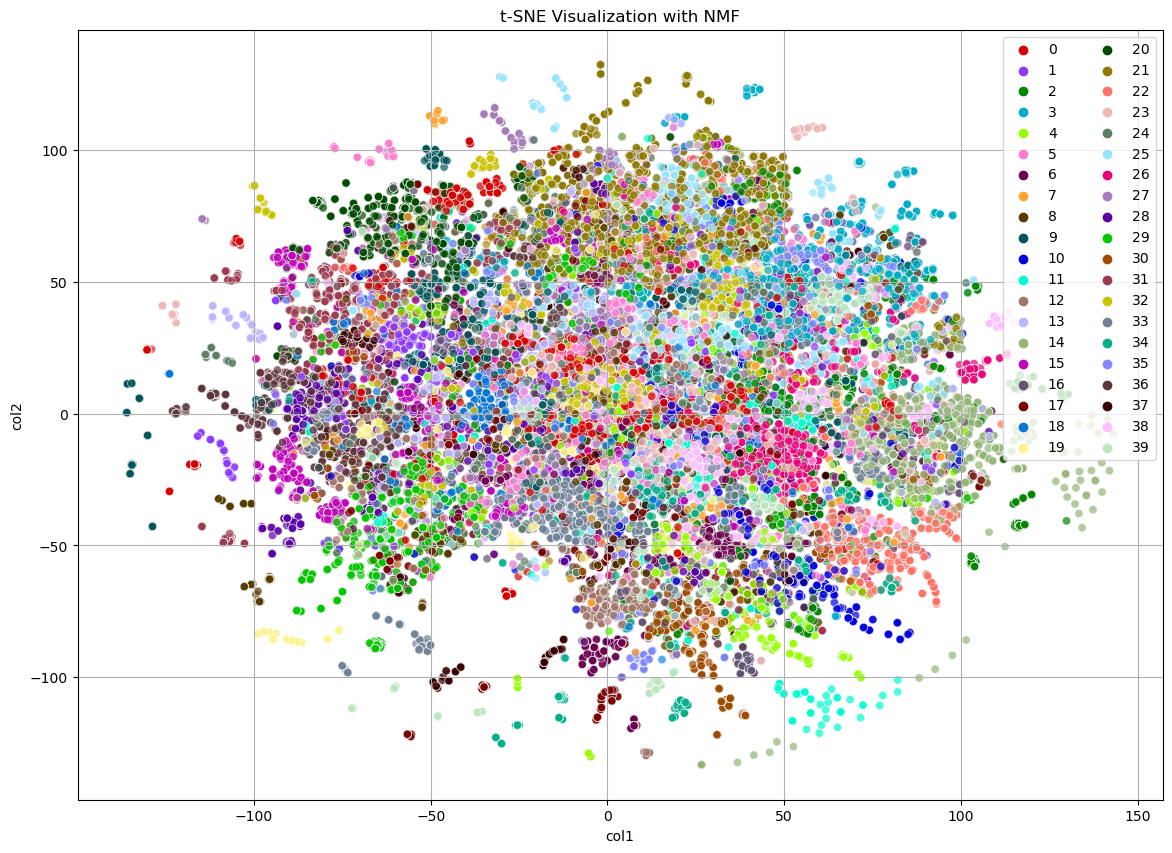

In [19]:
df = pd.DataFrame(tsne_matrix, columns=['col1', 'col2'])
df['labels'] = df_recipes_with_topics['Assigned Topic']

plt.figure(figsize=(14, 10))
sns.scatterplot(x='col1', y='col2', hue='labels', data=df, palette=palette, alpha=0.7)
plt.title('t-SNE Visualization with NMF')
plt.legend(ncol=2)
plt.grid()
plt.show()

In [20]:
labels = df_recipes_with_topics['Assigned Topic']
label_counts = Counter(labels)

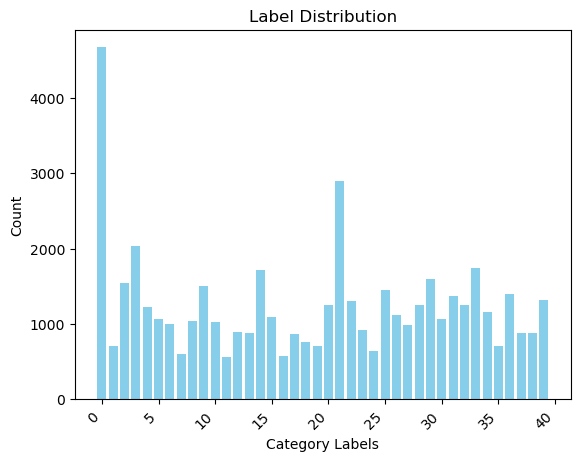

In [21]:
lab, counts = zip(*label_counts.items())

plt.bar(lab, counts, color='skyblue')
plt.xlabel('Category Labels')
plt.ylabel('Count')
plt.title('Label Distribution')
plt.xticks(rotation=45, ha='right')
plt.show()

In [22]:
allrecipt_imageDirs = []
kaggle_imageDirs = []
foodnetwork_imageDirs = []

for i in range(allrecipe_df.shape[0]):
    allrecipt_imageDirs.append('./data/images/allrecipes_images/image_' + str(i) + '.jpg')

for index, row in foodnetwork_df.iterrows():
    image_name = row['images'].split('/')[-1] or f'image_{index}.jpg'
    foodnetwork_imageDirs.append('./data/images/foodnetwork_images/' + image_name)
    
for imgName in kaggle_df['Image_Name']:
    kaggle_imageDirs.append('./data/images/kaggle_images/' + imgName + '.jpg')

all_imageDirs = allrecipt_imageDirs + foodnetwork_imageDirs + kaggle_imageDirs

dataset = []
badList = ['./foodnetwork_images/foodnetwork_images/1677268264252.jpeg',
           './foodnetwork_images/foodnetwork_images/1382967555384.jpeg']
for i in range(len(all_imageDirs)):
    if os.path.exists(all_imageDirs[i]) and all_imageDirs[i] not in badList:
        dataset.append((all_imageDirs[i], recipes_with_topics[i][1]))
np.save('./data/interim/LDA_dataset', dataset)

In [23]:
len(dataset)

49542